How do you call it sampling method if you generate the initial solution with random_spanning_tree?

In bipartition_tree, there is a gap of total numbers of candidates.

Maup operation. Fix the hole. 

Check if there is a projection issue. 

gerrychain assign areas using UTM (df.geometry.area) according to long and lat.

Assign the same colors for the same districts in two sided plot.

Hareketli ciz. 

Graph shouldn't contain geometry attribute. Define it in its class and call when necessary.

Can we find a solution for the regions with no any building to understand the figure better.

Ask: what should be the range of the topics to be included in the thesis? For example, should I put huff-puff  in the thesis? How detais?


Idea 1: Define facility_travel_radius and district_travel_diameter for each district. 

- candidate_travel_eccentiricity = max(travel(candidate, blocks) for block in district).  Save (candidate, candidate_radius) pairs. (defined as candidate_radius in the existing code)

- central_candidate = candidate with the minimum candidate_travel_eccentiricity. Deined as best_candidate in the code.

- facility_travel_radius: travel_eccentiricity of the central_candidate. 

- district_travel_diamater = max(tavel(block_x, block_y) for block_x, block_y in district)

central_candidate and facility_travel_radius is defined for just picking the facility of the district.

district_travel_diameter is defined for compactness. Use this in the objective function.


Idea 2: Use area & population density to pick the edges of cut edge set. Hierarchical facility location.

Idea 3: Integrate a flip operation.

Idea 4: Define different metrics in a metrics directory (See gerrychain metrics directory first).

Idea 5: Initial partition saving, result saving.

Idea 6: Put a treshold for max travel time: eliminate cut edges 

Idea 7: Consider existing centers. 

Idea 8: If the population of a block is zero, can you leave it out of the resdistricting without making the dual graph disconnected ?

Idea 9: You can define a bias for number of teams according to density? 

Idea 10: Remove blocks with population 0. Check out its continuity.

In [1]:
import matplotlib.pyplot as mplt
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas as gpd


from functools import partial
from tqdm import tqdm

from data_utils import DataHandler, Plot
from functools import partial

import updaters, accept, constraints
from tree import recursive_tree_part, bipartition_tree
from partition import Partition, GeographicPartition
from optimization import SingleMetricOptimizer
from constraints import contiguous
from chain import MarkovChain
from proposals import recom
#from pcompress import Record, Replay
import branca.colormap as cm
import branca

In [4]:
"Load data"
handler = DataHandler()

#graph = handler.load_graph()
chicago = handler.load_chicago()
candidates = handler.load_candidates()  # set of nodes
geo_centers = handler.load_geo_centers()
geo_candidates = handler.load_geo_candidates()
travel_times_walking = handler.load_travel_walking()
travel_times = handler.load_travel_times() # travel time between blocks is 10 minutes
newtravel = handler.load_newtravel()
geometries = handler.load_geometries()
plt = Plot(chicago, geo_candidates)


Since the sum of areas is the total population, the expected density of a district with average population is 1 for uniform distribution of population over the city.

density = area / pop = 1

$\bar{p}$: average population

$a(D)$: area of district $D$

$\bar{a}=\dfrac{A}{m}$ average area

$d(D)$ density of district $d$

$T_u$: subtree beneath node $u$ of spanning tree $T$. 

------------------------------------------------------------------------------------------

We define ideal population of a district as $k \cdot \bar{p}$, where $k =1,2$.

Let $C$ be the set of possible cut edges.

$e=(u,v) \in C$ iff $\dfrac{a(T_u)}{p(T_u)} \approx 1/k$, where $p(T_u) \approx k\bar{p}$ and $k =1,2$. And $k$ many D-N teams are assigned to its district.

Considering area based formulation, rather than travel radius, distributes primary care locations optimally far in distance with respect to population. 

Note: It is possible to consider $k \in \mathcal{Z}$ avoiding situtations $a(T_u) = m$ and $p(T_u) = mk$ with an appropriate algorithm (?) ... We don't want to assign only one facility to (?)..

Consider district $D$ has ideal population $k \cdot \bar{p}$ for some $k$.

Density of district $D$ is $d(D) = \dfrac{a(D)}{p(D)} = \dfrac{a(D)}{k \bar{p}}$ and $E[d(D)] = 1$. Since $k \bar{p}$ is constant, area of district $D$ will determine the density.

If we have $a(D) = \bar{a}$ and $k=2$, then $d(D) = \dfrac{1}{2}$.

Note that existince of  a district with a density less than 


In [3]:
from tree import random_spanning_tree
h = random_spanning_tree(graph)

In [4]:
"Initial partition"
pop = sum(graph.nodes[node]['pop'] for node in graph.nodes)
pop_target = pop / 100 
n_parts = 100
parts = list(range(100))
col = 'pop'

my_updaters = {
    "population": updaters.Tally(col, alias="population"),
    "cut_edges": updaters.cut_edges,
    "perimeter": updaters.perimeter,
    "area": updaters.Tally("area", alias="area"),}

initial_partition = GeographicPartition.from_random_assignment(travel_times=travel_times_walking,
    graph=graph,
    n_parts=n_parts,
    epsilon=0.01,
    pop_col=col,
    updaters=my_updaters)

In [ ]:
"Plot initial partition"
#m, regions, chicago, geocenters = initial_partition.plot_map()

In [5]:
"Proposal and constraints"
proposal = partial(
    recom,
    pop_col=col,
    pop_target=pop/n_parts,
    epsilon=0.02,
    node_repeats=1)
constraints = constraints.within_percent_of_ideal_population(initial_partition)

In [6]:
"Optimizer"
 
#sum_travel_radius = lambda p: np.sum(p.radius.values())
#num_cut_edges = lambda p: len(p["cut_edges"])
average_radius = lambda p: np.sum(((np.array(list(p.radius.values())) - np.sum(list(p.radius.values())) / len(p))**2))

optimizer = SingleMetricOptimizer(
    proposal=proposal,
    constraints=constraints,
    initial_state=initial_partition,
    optimization_metric=average_radius,
    maximize=False)

In [7]:
"Tilted Runs"

total_steps = 1000
partitions = {}

min_scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    min_scores_tilt[i] = optimizer.best_score
    partitions[i] = optimizer.best_part
final_partition = optimizer.best_partmem


100%|██████████| 1000/1000 [17:56<00:00,  1.08s/it]


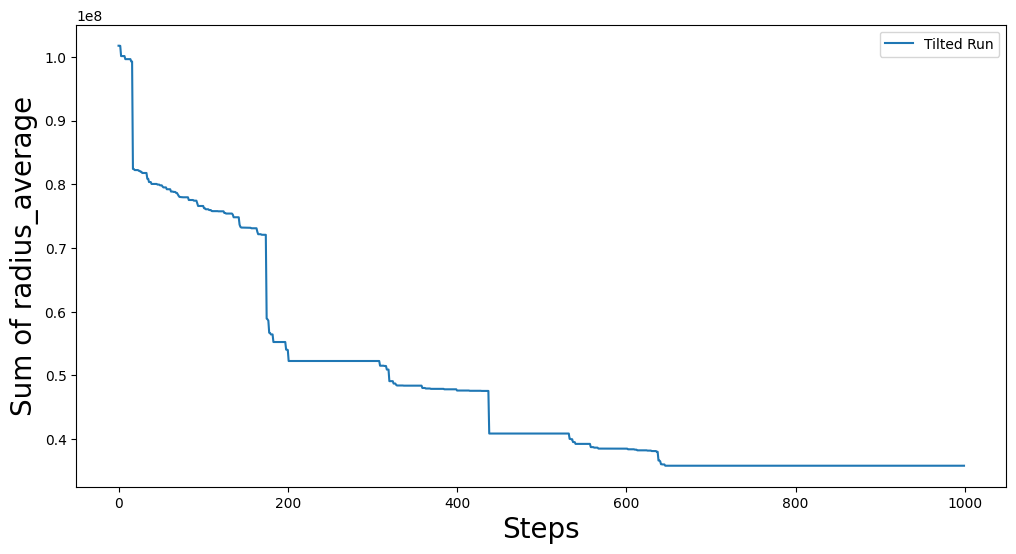

In [8]:
import matplotlib.pyplot as mplt
fig, ax = mplt.subplots(figsize=(12,6))
mplt.plot(min_scores_tilt, label="Tilted Run")
mplt.xlabel("Steps", fontsize=20)
mplt.ylabel("Sum of radius_average", fontsize=20)
mplt.legend()
mplt.show()

In [9]:
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition, final_partition)
fig


# Last result for average radius with fixed travel time

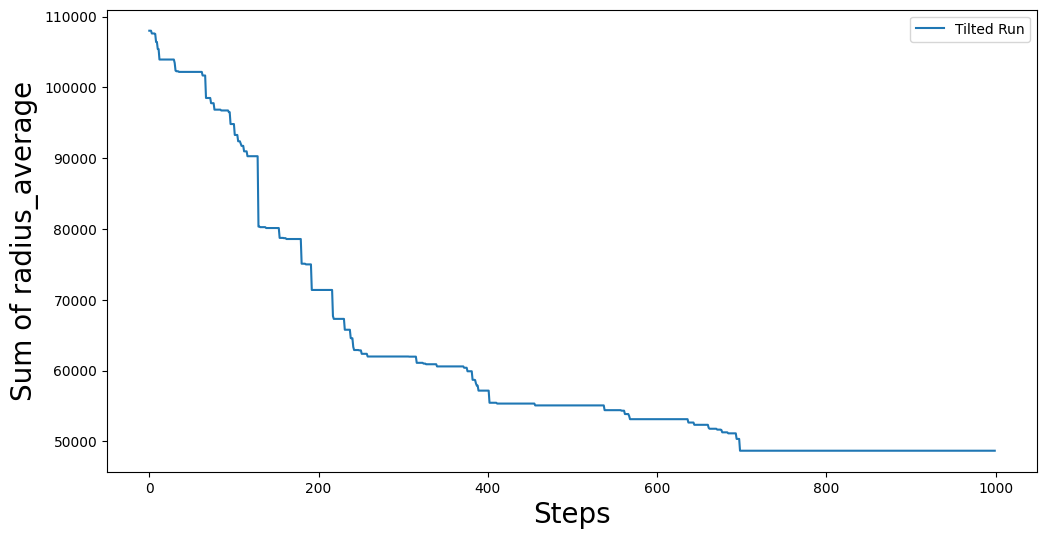

In [ ]:
import matplotlib.pyplot as mplt
fig, ax = mplt.subplots(figsize=(12,6))
mplt.plot(min_scores_tilt, label="Tilted Run")
mplt.xlabel("Steps", fontsize=20)
mplt.ylabel("Sum of radius_average", fontsize=20)
mplt.legend()
mplt.show()

In [ ]:
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition, final_partition)
fig

Python(45527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
#sum_travel_radius = lambda p: np.sum(p.radius.values())
num_cut_edges = lambda p: len(p["cut_edges"])
average_radius = lambda p: np.sum(abs((np.array(list(p.radius.values())) - np.sum(list(p.radius.values())) / len(p))**2))

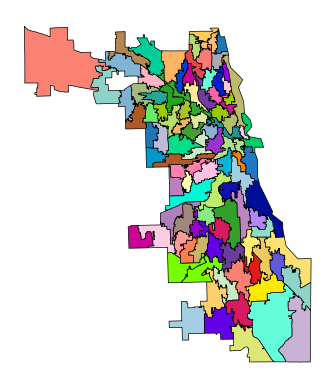

In [ ]:
import gerrytools

import matplotlib.pyplot as plt
from gerrytools.scoring import *
from gerrytools.plotting import *
import gerrytools.plotting.colors as colors
import numpy as np

N = len(regions_final_new)

dists = regions_final_new.to_crs("EPSG:3857")
dists["final_district"] = dists["final_district"].astype(int)
dists=dists.sort_values(by="final_district")
dists["colorindex"] = list(range(N))
dists["color"] = colors.districtr(N)

ax = drawplan(chicago, assignment="final_district", overlays=None)

In [ ]:
import maup
from maup import repair

In [ ]:
maup.doctor(chicago)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/maup/repair.py:249: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


There are 1 holes.


False

In [ ]:
repair.count_holes(chicago)

1

In [ ]:
maup.repair.autorepair(chicago)

In [ ]:
final_partition.plot(chicago, figsize=(10, 10), cmap="tab20")
mplt.axis('off')
mplt.show()

In [ ]:
import numpy as np
print("1) Number of Cut Edges")
print("    Best score: ", optimizer.best_score)
print("    Initial score: ", len(initial_partition["cut_edges"]))
print("2) Sum of Travel Radius")
print("    Initial: ", np.sum(list(initial_partition.radius.values())))
print("    Final: ", np.sum(list(final_partition.radius.values())))
print("3) Sum of Radius Devitation")
print("    Initial: ", sum(abs(np.array(list(initial_partition.radius.values())) - sum(x for x in initial_partition.radius.values()) / len(initial_partition))**2))
print("    Final: ", sum(abs(np.array(list(final_partition.radius.values())) - sum(x for x in final_partition.radius.values())/ len(final_partition))**2 ))

1) Number of Cut Edges
    Best score:  42675.99999999999
    Initial score:  7217
2) Sum of Travel Radius
    Initial:  15200
    Final:  14820
3) Sum of Radius Devitation
    Initial:  108000.0
    Final:  42675.99999999998


In [ ]:
"""pcompress
radiuss = {}
i=0
for optimizer in Record(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True), "pa-run.chain"):
    # normal chain stuff here
    partition = optimizer.best_part
    radius = partition.radius
    radiuss[i] = radius 
    i+= 1"""

In [ ]:
"Watch"
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as mplt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []

for i, partition in enumerate(recom_chain):
    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        district_data.append((i, district_name, population, perimeter, area))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)
#df.head(5)
#The perimeter and area attributes are actually not present in the MN_precincts.geojson file, but the GeographicPartition class will calculate them at instantiation time using the geometries provided in the file.

# Save

In [ ]:
#final_partition = optimizer.best_part
#for partition in pcompress.Record(optimizer, "run.chain", executable="pv", extreme=True):
#    print(partition.population)

#final_partition = optimizer.best_part
#handler = DataHandler()
#handler.load_final_assignment()
#final_partition = optimizer.best_part
#final_assignment = dict(final_partition.assignment)
#pd.to_pickle(final_assignment, '/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/prepared_data/final_assignment.pkl')
#final_assignment = handler.load_final_assignment()
#final_assignment = Partition(graph, final_assignment, updaters=my_updaters)

# Local Search

In [ ]:
# We can run each of the optimization methods and collect some data

total_steps = 10000

# Short Bursts
min_scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score

# Simulated Annealing
min_scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(200, 800),
        beta_magnitude=1,
        with_progress_bar=True
    )
):
    min_scores_anneal[i] = optimizer.best_score